## Association subtypes language task

In [1]:
import seaborn as sns
import os
import json
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
import scipy.io #read .mat files
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVR
from sklearn import preprocessing, linear_model
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

In [3]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [6]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

## machine learning function

In [7]:
def RandomForest_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : Random forest regression
    rfr = RandomForestRegressor(n_estimators=1000,oob_score=True,n_jobs=-1)
    skf = KFold(n_splits)
    feimp = np.zeros((skf.n_splits,X.shape[1]))
    scores = np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)
        
        rsq = r2_score(y_test, y_pred)
        scores[c,:] = rsq
        
        feimp[c,:] = rfr.feature_importances_[:]
        
        std[c,:] = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
        #     plt.figure()
        #     plt.scatter(y_test, y_test, edgecolor='k',
        #             c="navy", s=s, marker="s", alpha=a, label="Test Data")
        
        #     plt.scatter(y_train, pred, edgecolor='k',
        #             c="c", s=s, marker="^", alpha=a,
        #             label="Prediction -- RF score=%.2f" % rsq)
        #     plt.title("Prediction on subset number {}".format(c))
        #     plt.legend()
        #     plt.show()
    print('Mean R-Squared score: %.3f' % scores.mean()) 
    return x_test, y_test,feimp, scores,std

In [8]:
def SVR_apply(X, y,n_splits=3,kern='linear',flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : SVR
    clf = SVR(kernel=kern)
    # grid search cv
    #clf = GridSearchCV(clf, cv=10,param_grid={"C": np.logspace(-2, 2, 10),"gamma": np.logspace(-2, 2, 10)})
    clf = GridSearchCV(clf, cv=5,param_grid={"C": np.logspace(-2, 3, 10),
                                             "gamma": np.logspace(-2, 2, 10)},n_jobs=-1)
    #clf = GridSearchCV(clf, cv=5,param_grid={"C": np.logspace(-2, 3, 5),'degree':[3,4,5]},n_jobs=6)
    
    
    skf = KFold(n_splits)
    scores = np.zeros((skf.n_splits,1))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        rsq = r2_score(y_test, y_pred)
        scores[c,:] = rsq
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            #fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            #plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            #fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            #plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
    print('Mean R-Squared score: %.3f' % scores.mean()) 
    return x_test, y_test,scores

In [19]:
def Linear_SVR_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    skf = KFold(n_splits)
    
    # apply machine learning :  LinearSVR
    clf = LinearSVR(random_state=0)
    
    Coeff = np.zeros((skf.n_splits,X.shape[1]))
    SquaredError = np.zeros((skf.n_splits,1))
    Rsquared =  np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
    
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        Coeff[c,:] = clf.coef_[:]
        SquaredError[c,:] = mean_squared_error(y_test, y_pred)
        Rsquared[c,:] = r2_score(y_test,y_pred)
        std[c,:] = np.std([coefi for coefi in clf.coef_],axis=0)
        
        # Plot outputs
        if flag_plot :
            
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            #fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            #plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            #fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            #plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % Rsquared[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
    print('Mean R-Squared score: %.3f' % Rsquared.mean()) 
    return Coeff,std, SquaredError,Rsquared

In [20]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30,40,50,100],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,6,8,10,12,14],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [21]:
def RFR(X_train, X_test, y_train, y_test, best_params):
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    rfr.fit(X_train,y_train)
    
    y_pred = rfr.predict(X_test)
    
    rsq = r2_score(y_test, y_pred)
    feimp = rfr.feature_importances_[:]
    std_feimp = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
        
    print ("R2 score: %.3f" % rsq)
    return y_pred,rsq,feimp,std_feimp

In [22]:
def RandomForestOptim_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : Random forest regression
    rfr = RandomForestRegressor(n_estimators=4000,oob_score=True,n_jobs=-1)
    skf = KFold(n_splits)
    feimp_c = np.zeros((skf.n_splits,X.shape[1]))
    scores_c = np.zeros((skf.n_splits,1))
    std_c =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Grid search
        best_score, best_params = Grid_Search_CV_RFR(x_train, y_train)
        #Best params
        y_pred,rsq,feimp,std_feimp = RFR(x_train, x_test, y_train, y_test, best_params)
        print ("Best Score:%.03f" % best_score)
        print ("Best params:%s" % best_params)
        #stack results
        feimp_c[c,:] = feimp
        scores_c[c,:] = rsq
        std_c[c,:] = std_feimp
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
            
    print('Mean R-Squared score: %.3f' % scores_c.mean()) 
    return x_test, y_test,feimp_c, scores_c,std_c

In [23]:
def LinearRegression_apply(X, y,n_splits=3,flag_plot = True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    Coeff:   Mean Estimated coefficients for the linear regression problem
    SquaredError: Mean Squared Error
    Rsquared:     Mean coefficient of determination
    """
    # apply machine learning : Linear Regression
    regr = linear_model.LinearRegression(n_jobs=-1)
    skf = KFold(n_splits)
    Coeff = np.zeros((skf.n_splits,X.shape[1]))
    SquaredError = np.zeros((skf.n_splits,1))
    Rsquared =  np.zeros((skf.n_splits,1))
    #std =  np.zeros((skf.n_splits,X.shape[1]))
    #feimp = np.zeros((skf.n_splits,X.shape[1]))
    
    #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        regr.fit(x_train, y_train)
        y_pred = regr.predict(x_test)
        
        # fit an Extra Trees model to the data
#         forest = ExtraTreesRegressor(n_estimators=400,
#                                      random_state=0,n_jobs=-1)
        #forest.fit(x_train, y_train)
        
        Coeff[c,:] = regr.coef_[:]
        SquaredError[c,:] = mean_squared_error(y_test, y_pred)
        Rsquared[c,:] = r2_score(y_test,y_pred)
        #std[c,:] = np.std([coefi for coefi in forest.feature_importances_],axis=0)
        #feimp[c,:] = forest.feature_importances_
        
        if flag_plot:
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7
            plt.scatter(x_test, y_test,  edgecolor='k',
                        c="navy", s=s, marker="s", alpha=a, 
                        label="Test Data")
            plt.scatter(x_test, y_pred, edgecolor='k',c="c",
                        s=s, marker="^", alpha=a,
                        label="Predicted data -- RSquared=%.2f" % Rsquared[c,:])
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
        
    #print('Mean R-Squared score: %.3f' % Rsquared.mean())    
    return Coeff, SquaredError,Rsquared

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [25]:
# Clusters alias
dict_clusters_names = {'Cluster_1' : 'Physio',
                 'Cluster_2' : 'Neg_affec',
                 'Cluster_3' : 'Speed',
                 'Cluster_4' : 'Somatic',
                 'Cluster_5' : 'Desord_ext',
                 'Cluster_6' : 'Pos_affetc',
                 'Cluster_7' : 'Desord_int',
                 'Cluster_8' : 'Exec_mot',
                 'Cluster_9' : 'Sens_mot_mem',
                 'Cluster_10' : 'Exec_lang'}

In [26]:
#  Set path
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
list_subtype_folder = ['subtype_3_spm_LANGUAGE_18-Oct-2017', 
                       'subtype_4_spm_LANGUAGE_18-Oct-2017',
                       'subtype_5_spm_LANGUAGE_18-Oct-2017',
                       'subtype_6_spm_LANGUAGE_18-Oct-2017',
                       'subtype_7_spm_LANGUAGE_18-Oct-2017',
                       'subtype_8_spm_LANGUAGE_18-Oct-2017',
                       'subtype_9_spm_LANGUAGE_18-Oct-2017',
                       'subtype_10_spm_LANGUAGE_18-Oct-2017']

In [58]:
#  Set path
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
list_subtype_folder = ['subtype_5_spm_SOCIAL_18-Oct-2017'] 

## Get R-squared from NIAK

In [59]:
for ind_f , task_folder in enumerate(list_subtype_folder):
    
    # set path and task name
    path_subtype = os.path.join(path_root,task_folder);
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    # number of subtype
    nb_sbt = natural_keys(path_subtype)[9]
    # task name
    task_name = natural_keys(path_subtype)[10][5:-1]
    # List phenotypes
    list_pheno  = [f for f in os.listdir(path_association)]
    list_pheno.sort(key=natural_keys)
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    # List subtype
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    # Create R-squared table to be used in R
    for trial_name in list_trial :
        # build R2 table for radar plot
        for ix, pheno_name in enumerate(list_pheno):
            mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
            %octave_push mat_file
            %octave mat_load = load(mat_file);
            %octave_pull mat_load
            pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
            if ix == 0:
                pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
            else:
                pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)

        pheno_r2_final.columns = list_pheno
        pheno_r2_final.index = list_subtype
        pheno_r2_final = pd.DataFrame(pheno_r2_final)
        pheno_r2_final.rename(columns=dict_clusters_names).to_csv(os.path.join(path_subtype,
                                                                               '{}_r2.csv'.format(trial_name)))

# Radar plot for all subtype : R-squared NIAK

### On first run in new machine do
Step 1 — Installing System Dependencies for devtools

`sudo apt-get install build-essential libcurl4-gnutls-dev libxml2-dev libssl-dev libcairo2-dev r-cran-stringr`

Step 2 — Installing the Devtools Package

```sudo -i R
install.packages('devtools')
devtools::install_github("hadley/svglite")
devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)```

In [60]:
%%R
library(ggradar)
library(svglite)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

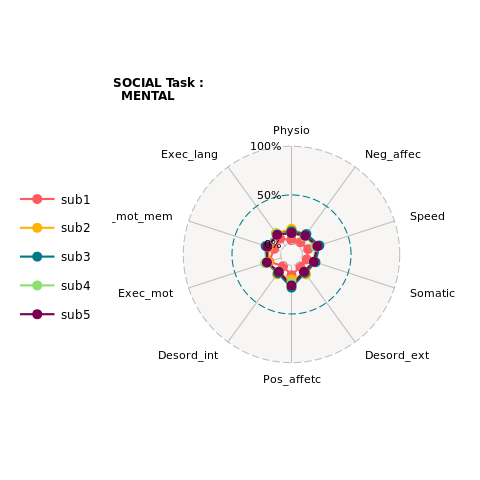

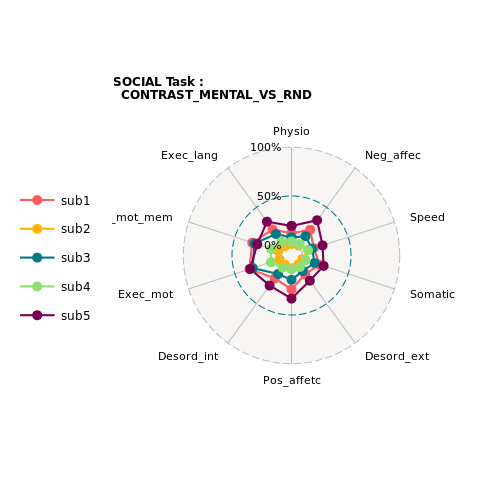

In [61]:
%%R -i path_root,list_subtype_folder,list_trial,task_name

for (tt in list_subtype_folder) {
    path_subtype = paste(path_root,tt,'/',sep = '')
    for (ii in list_trial) {
        MyData <- read.csv(file=paste(path_subtype,ii,"_r2.csv",sep = ''))
        # plot R2 radar plot
        image_radar=ggradar(MyData, 
                            grid.min = 0,
                            grid.mid = 0.05, 
                            grid.max = 0.1, 
                            axis.label.size = 4, 
                            grid.label.size = 5 ,
                            legend.text.size =5,
                            group.line.width = 1,
                            group.point.size = 4)  +
        theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
        ggtitle(paste(task_name,' Task : \n  ',toupper(ii),sep = ''))
        print(image_radar)
        ggsave(file=paste(path_subtype,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
    }
}


# Radar plot for all subtype : R-squared Machine learning

In [62]:
# import pheno cluster variable names
dict_clusters = json.load(open(os.path.join(path_root,'pheno/hcp_bootstraped_pheno_clusters.txt')))

In [63]:
# import all pheno non clustered data
all_pheno = pd.read_csv(os.path.join(path_root,'pheno/hcp_all_pheno_clean_nonan_norm.csv'))
# set subject names with Prefix HCP
all_pheno.rename(columns={'Unnamed: 0': 'ID'},inplace=True)
all_pheno['ID'] = 'HCP'+ all_pheno['ID'].astype(str)

In [64]:
path_subtype

'/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/subtype_5_spm_SOCIAL_18-Oct-2017'

In [68]:
# import and merge all weight and pheno data
dict_all_weight_pheno = {}
dict_all_weight_pheno_clust = {}
dict_all_weight_pheno_clust_json = {}

for ind_f , task_folder in enumerate(list_subtype_folder):
    
    # set path and task name
    path_subtype = os.path.join(path_root,task_folder);
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    # number of subtype
    nb_sbt = natural_keys(path_subtype)[9]
    # task name
    task_name = natural_keys(path_subtype)[10][5:-1]
    # List phenotypes
    list_pheno  = [f for f in os.listdir(path_association)]
    list_pheno.sort(key=natural_keys)
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    # List subtype
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    
    # collect weight data
    for ind_t, trial_name in enumerate(list_trial) :
        # collect all pheno data
        all_pheno_clust = []
        names_pheno = []
        for ix, pheno_name in enumerate(list_pheno):
            #from IPython.core.debugger import Tracer; Tracer()() 
            mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
            %octave_push mat_file
            %octave mat_load = load(mat_file);
            %octave_pull mat_load
            model_x_norm = mat_load['model_norm']['x']
            model_labels_y_norm = mat_load['model_norm']['labels_y']
            model_labels_x_norm = mat_load['model_norm']['labels_x']

            my_pheno = np.array(model_x_norm[:,1])
            my_pheno_name= model_labels_y_norm[1]
            all_pheno_clust.append(my_pheno)
            names_pheno.append(my_pheno_name)
        
        # extract partitioning of clusters from mat file 
        sim_p= os.path.join(path_networks,trial_name,'subtype_{}.mat'.format(trial_name))
        %octave_push sim_p
        %octave mat_load = load(sim_p);
        %octave_pull mat_load
        stack_subj_part = np.concatenate((np.vstack(mat_load['list_subject']),mat_load['part'].astype('int')),axis=1)
        
        # make dataframe out of partition and IDs
        subj_part_df = pd.DataFrame(stack_subj_part,columns=['ID','part'])
        subj_part_df.loc[:,'part'] = subj_part_df.part.astype(int)
        
        # create pheno dataframe
        all_pheno_clust = np.concatenate([model_labels_x_norm[...,None],np.transpose(all_pheno_clust)],axis=1)
        all_pheno_clust_df = pd.DataFrame(all_pheno_clust,columns=np.append('ID',  list_pheno))
        all_pheno_clust_df['ID'] = all_pheno_clust_df.ID.str.strip()
        
        #collect weight and create dataframe
        weight_file = os.path.join(path_networks,'{}/sbt_weights_net_{}.csv'.format(trial_name,trial_name))
        weight_df = pd.read_csv(weight_file)
        column_names =np.append('ID',  list_subtype)
        weight_df.columns= column_names
        weight_df['ID'] = weight_df.ID.str.strip()
        
        dfs = [subj_part_df,weight_df,all_pheno_clust_df,all_pheno]
        df_final = reduce(lambda left,right: pd.merge(left,right,on='ID'), dfs)

#         # merge weight amd pheno dataframe
#         weight_pheno_clust_df=pd.merge(weight_df,all_pheno_clust_df,on='ID',how='left')
#         # save it csv
#         weight_pheno_clust_df.to_csv(os.path.join(path_subtype,'{}_weight_pheno_subtype.csv'.format(trial_name)))

        # stack to dictionary
        dict_all_weight_pheno_clust[task_name + "_" + 
                                    trial_name + "_" + 
                                    str(nb_sbt) + '_subtypes'] = df_final
#         # stack to json to be saved later
#         dict_all_weight_pheno_clust_json[task_name + "_" +
#                                          trial_name + "_" +
#                                          str(nb_sbt) + '_subtypes'] = weight_pheno_clust_df.to_json(orient='split')
#         # Merge all pheno with subtype weights
#         all_pheno_pruned = pd.merge(weight_pheno_clust_df[['ID']+list_subtype],all_pheno,on='ID',how='left')
#         # Drop NaN
#         all_pheno_pruned.dropna(inplace=True)
#         dict_all_weight_pheno[task_name + "_" +
#                               trial_name + "_" +
#                               str(nb_sbt) + '_subtypes'] = all_pheno_pruned

In [70]:
dict_all_weight_pheno_clust.keys()

dict_keys(['SOCIAL_contrast_mental_vs_rnd_5_subtypes', 'SOCIAL_mental_5_subtypes'])

### Select task, subtype and trial to be used

In [78]:
# select task and trial and subtype
trial_name = 'contrast_mental_vs_rnd'
final_df = dict_all_weight_pheno_clust[task_name + "_" +
                            trial_name + "_" +
                            str(nb_sbt) + '_subtypes']
print('Selection  \n \t Task: {}  \n \t Subtype numb: {}  \n \t Trial: {}'.format(task_name,
                                                                              nb_sbt,
                                                                              trial_name))

Selection  
 	 Task: SOCIAL  
 	 Subtype numb: 5  
 	 Trial: contrast_mental_vs_rnd


In [79]:
# threshold subject weight
stack_df_tmp= [df_final[df_final.iloc[:,2:nb_sbt+2].apply(lambda x: abs(x) > 0.001, axis=1)[col]] for col in list_subtype]
# stack vertically all subject
final_df = pd.concat(stack_df_tmp)
# remove duplicate 
final_df = final_df[~final_df.ID.duplicated()]
# visualize shape 
final_df.shape

(784, 88)

In [80]:
final_df.head()

,ID,part,sub1,sub2,sub3,sub4,sub5,Cluster_1,Cluster_2,Cluster_3,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100206,2,-0.181,0.183,0.201,-0.124,-0.067,-0.265891,1.29877,0.0596241,...,0.598684,1.129563,2.036715,1.146888,2.254271,1.501363,2.590293,2.105813,1.602376,0.819715
1,HCP100307,1,0.456,-0.015,-0.391,0.123,-0.328,-0.561032,0.537988,-0.945504,...,-0.560381,-0.681798,-0.885736,-0.323938,-0.682909,-0.624284,-0.684158,-0.707406,-0.659096,-0.431086
2,HCP100408,5,-0.286,0.120,0.288,-0.153,0.112,1.25236,0.107359,-0.514926,...,0.405506,-0.681798,-0.980008,-0.210797,-0.682909,-0.431043,-0.684158,-0.707406,-0.659096,-0.431086
3,HCP100610,4,-0.014,-0.110,-0.104,0.257,-0.104,0.9698,-0.345983,-0.874968,...,-0.753559,-0.138390,0.434081,-0.323938,-0.682909,-0.624284,-0.684158,2.602263,-0.833056,-0.639553
4,HCP101006,2,0.022,0.156,0.033,-0.177,-0.013,0.687084,0.0529392,0.0624932,...,-0.367204,-0.681798,-1.168554,-0.210797,-0.682909,-0.624284,-0.684158,-0.707406,-0.833056,-0.639553


In [36]:
#import all task_weight
all_task_weight = pd.read_csv(os.path.join(path_root,'pheno','all_task_weight_sub_3-10.csv'))

In [151]:
# select all tasks weights from one subtype
select_cols = [col for col in all_task_weight.columns if task_name[:3]+'_'  in col and '_' in col]
all_tasks_weight_selection = all_task_weight[['ID']+select_cols]
all_tasks_weight_selection = all_tasks_weight_selection.dropna()

In [152]:
all_tasks_weight_selection.head()

,ID,SOC_mental_sub1_3,SOC_mental_sub2_3,SOC_mental_sub3_3,SOC_mental_sub1_10,SOC_mental_sub2_10,SOC_mental_sub3_10,SOC_mental_sub4_10,SOC_mental_sub5_10,SOC_mental_sub6_10,...,SOC_contrast_mental_vs_rnd_sub3_7,SOC_contrast_mental_vs_rnd_sub4_7,SOC_contrast_mental_vs_rnd_sub5_7,SOC_contrast_mental_vs_rnd_sub6_7,SOC_contrast_mental_vs_rnd_sub7_7,SOC_contrast_mental_vs_rnd_sub1_5,SOC_contrast_mental_vs_rnd_sub2_5,SOC_contrast_mental_vs_rnd_sub3_5,SOC_contrast_mental_vs_rnd_sub4_5,SOC_contrast_mental_vs_rnd_sub5_5
0,HCP100206,0.138,0.261,-0.247,-0.090,0.258,-0.011,0.174,-0.179,0.257,...,-0.181,-0.058,0.003,0.183,0.201,-0.181,0.183,0.201,-0.124,-0.067
1,HCP100307,-0.466,-0.612,0.612,0.046,-0.619,-0.241,-0.395,0.426,-0.576,...,0.456,-0.262,-0.106,-0.015,-0.391,0.456,-0.015,-0.391,0.123,-0.328
2,HCP100408,0.076,0.157,-0.147,-0.172,0.145,0.037,-0.082,-0.180,0.173,...,-0.286,0.094,0.002,0.120,0.288,-0.286,0.120,0.288,-0.153,0.112
3,HCP100610,-0.318,-0.244,0.275,-0.146,-0.252,0.029,-0.206,0.246,-0.221,...,-0.014,-0.202,0.363,-0.110,-0.104,-0.014,-0.110,-0.104,0.257,-0.104
4,HCP101006,-0.226,-0.251,0.259,-0.153,-0.244,-0.082,-0.048,0.226,-0.252,...,0.022,0.041,-0.230,0.156,0.033,0.022,0.156,0.033,-0.177,-0.013


In [153]:
# merge all weights and all pheno
merge_all = pd.merge(all_tasks_weight_selection,final_df,on='ID',how='left').dropna()

In [154]:
merge_all.head()

,ID,SOC_mental_sub1_3,SOC_mental_sub2_3,SOC_mental_sub3_3,SOC_mental_sub1_10,SOC_mental_sub2_10,SOC_mental_sub3_10,SOC_mental_sub4_10,SOC_mental_sub5_10,SOC_mental_sub6_10,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100206,0.138,0.261,-0.247,-0.090,0.258,-0.011,0.174,-0.179,0.257,...,0.598684,1.129563,2.036715,1.146888,2.254271,1.501363,2.590293,2.105813,1.602376,0.819715
1,HCP100307,-0.466,-0.612,0.612,0.046,-0.619,-0.241,-0.395,0.426,-0.576,...,-0.560381,-0.681798,-0.885736,-0.323938,-0.682909,-0.624284,-0.684158,-0.707406,-0.659096,-0.431086
2,HCP100408,0.076,0.157,-0.147,-0.172,0.145,0.037,-0.082,-0.180,0.173,...,0.405506,-0.681798,-0.980008,-0.210797,-0.682909,-0.431043,-0.684158,-0.707406,-0.659096,-0.431086
3,HCP100610,-0.318,-0.244,0.275,-0.146,-0.252,0.029,-0.206,0.246,-0.221,...,-0.753559,-0.138390,0.434081,-0.323938,-0.682909,-0.624284,-0.684158,2.602263,-0.833056,-0.639553
4,HCP101006,-0.226,-0.251,0.259,-0.153,-0.244,-0.082,-0.048,0.226,-0.252,...,-0.367204,-0.681798,-1.168554,-0.210797,-0.682909,-0.624284,-0.684158,-0.707406,-0.833056,-0.639553


##  K-Nearest Neighbors: Classification and Regression

### Regression 
- X  : Pheno data non-clustered
- y : Subtypes weights

In [155]:
x_labels = all_tasks_weight_selection.columns.drop('ID')
x_labels

Index(['SOC_mental_sub1_3', 'SOC_mental_sub2_3', 'SOC_mental_sub3_3',
       'SOC_mental_sub1_10', 'SOC_mental_sub2_10', 'SOC_mental_sub3_10',
       'SOC_mental_sub4_10', 'SOC_mental_sub5_10', 'SOC_mental_sub6_10',
       'SOC_mental_sub7_10',
       ...
       'SOC_contrast_mental_vs_rnd_sub3_7',
       'SOC_contrast_mental_vs_rnd_sub4_7',
       'SOC_contrast_mental_vs_rnd_sub5_7',
       'SOC_contrast_mental_vs_rnd_sub6_7',
       'SOC_contrast_mental_vs_rnd_sub7_7',
       'SOC_contrast_mental_vs_rnd_sub1_5',
       'SOC_contrast_mental_vs_rnd_sub2_5',
       'SOC_contrast_mental_vs_rnd_sub3_5',
       'SOC_contrast_mental_vs_rnd_sub4_5',
       'SOC_contrast_mental_vs_rnd_sub5_5'],
      dtype='object', length=104)

In [156]:
y_labels = all_pheno_clust_df.columns.drop('ID')
y_labels

Index(['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5',
       'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9', 'Cluster_10'],
      dtype='object')

In [176]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.cross_validation import train_test_split

# prepare X's and y
#X =  final_df[all_pheno.columns.drop('ID')].as_matrix()
#X =  final_df[list_pheno].as_matrix()
#y= final_df['sub2'].as_matrix()
X_R1 =  merge_all[x_labels].as_matrix()
y_R1 = merge_all[y_labels].ix[:,5].as_matrix()




X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

knnreg = KNeighborsRegressor(n_neighbors = 50).fit(X_train, y_train)

#print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

#print( "Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, knnreg.predict(X_train)))
# Run model
# mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(train_x, train_y)
# print( "Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
# print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))

R-squared test score: 0.010


In [173]:
train_x.shape[0]

541

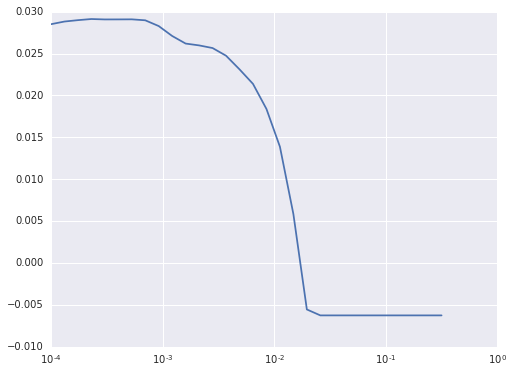

In [227]:
lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

cv = ShuffleSplit(X.shape[0],n_iter=30, test_size=0.2, random_state=0)
cv = n_folds
clf = GridSearchCV(lasso, tuned_parameters, cv=cv, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

In [232]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

for Model in [Ridge, Lasso]:
    model = Model(alpha=0.0005)
    print('%s: %s' % (Model.__name__,
                      cross_val_score(model, X, y).mean()))

Ridge: 0.026633608774
Lasso: 0.0290131663585


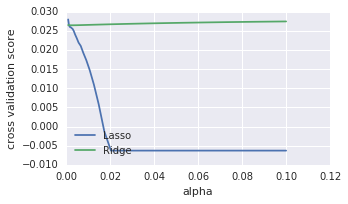

In [229]:
import numpy as np
from matplotlib import pyplot as plt

alphas = np.logspace(-3, -1, 30)

plt.figure(figsize=(5, 3))

for Model in [Lasso, Ridge]:
    scores = [cross_val_score(Model(alpha), X, y, cv=3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

ValueError: Unknown label type: 'unknown'

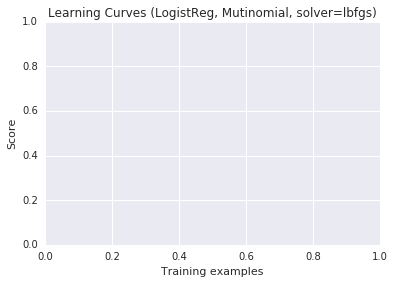

In [224]:
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit

cv = ShuffleSplit(X.shape[0],n_iter=30, test_size=0.2, random_state=0)
#title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' %classifier.best_estimator_.gamma
title = 'Learning Curves (LogistReg, Mutinomial, solver=lbfgs)'
estimator = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
#estimator = SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
plot_learning_curve(estimator, title, X, y, cv=cv)
plt.show()

In [79]:
from sklearn.svm import SVC
estimator = SVC(kernel='linear')

from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(train_x.shape[0], n_iter=30, test_size=0.2, random_state=0)

from sklearn.grid_search import GridSearchCV
import numpy as np
gammas = np.logspace(-6, -1, 10)
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(gamma=gammas))
classifier.fit(train_x, train_y)

GridSearchCV(cv=ShuffleSplit(483, n_iter=30, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [39]:
list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
all_pheno.columns.drop('ID')
asso_test_df = pd.DataFrame(mul_lr.coef_,columns=all_pheno.columns.drop('ID'),index=list_subtype)

In [41]:
asso_test_df.max()[asso_test_df.max() > 0.5]

BMI                 0.744277
PMAT24_A_CR         0.716194
DDisc_AUC_40K       0.513890
SCPT_TP             0.520683
FearAffect_Unadj    0.654826
LifeSatisf_Unadj    0.539896
Friendship_Unadj    0.521046
PercStress_Unadj    0.520810
SelfEff_Unadj       0.709021
Strength_Unadj      0.613945
ASR_Anxd_Pct        0.858764
ASR_Soma_Pct        0.649916
ASR_Attn_Pct        0.721608
ASR_Aggr_Pct        0.566385
ASR_Rule_Pct        0.509862
ASR_Intn_T          0.541194
DSM_Depr_Pct        0.655758
DSM_Somp_Pct        0.538064
DSM_Adh_Pct         0.589777
DSM_Antis_Pct       0.518953
dtype: float64

In [559]:
trial_name

'contrast_mental_vs_rnd'

In [560]:
list_trial = 'contrast_mental_vs_rnd'

In [561]:
asso_test_df.rename(columns=dict_clusters_names).to_csv(os.path.join(path_root,
                                                                     'subtype_10_spm_SOCIAL_18-Oct-2017/{}_r2_logReg.csv'.format(trial_name)))

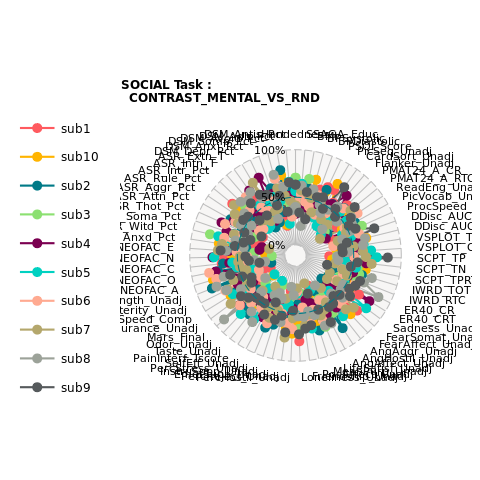

In [562]:
%%R -i path_root,list_subtype_folder,list_trial,task_name

path_subtype = paste(path_root,'subtype_10_spm_SOCIAL_18-Oct-2017','/',sep = '')
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_subtype,ii,"_r2_logReg.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = -1.5,
                        grid.mid = 0, 
                        grid.max = 1.5, 
                        axis.label.size = 4, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(task_name,' Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_subtype,ii,"_logReg_coeff.svg",sep = ''), plot=image_radar, width=10, height=8)
}


In [36]:
# extract partitioning of clrusters from mat file 
sim_p= os.path.join(path_networks,trial_name,'subtype_{}.mat'.format(trial_name))
%octave_push sim_p
%octave mat_load = load(sim_p);
%octave_pull mat_load
stack_subj_part = np.concatenate((np.vstack(mat_load['list_subject']),mat_load['part'].astype('int')),axis=1)

# make dataframe out of partition and IDs
subj_part_df = pd.DataFrame(stack_subj_part,columns=['ID','part'])
subj_part_df.loc[:,'part'] = subj_part_df.part.astype(int)

In [68]:
# Create estimated R-squared table to be used in R
high_r2_dict= dict()
for ind_f , task_folder in enumerate(list_subtype_folder):
    
    # set path and task name
    path_subtype = os.path.join(path_root,task_folder);
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    # number of subtype
    nb_sbt = natural_keys(path_subtype)[9]
    # task name
    task_name = natural_keys(path_subtype)[10][5:-1]
    # List phenotypes
    list_pheno  = [f for f in os.listdir(path_association)]
    list_pheno.sort(key=natural_keys)
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    # List subtype
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    
    # Create estimated R-squared table to be used in R
    for trial_name in list_trial :
        # build R2 table for radar plot
        #from IPython.core.debugger import Tracer; Tracer()() 
        # Set data X Y weight_pheno_clust_df
        X = weight_pheno_clust_df[list_pheno]
        x = X.values
        Rsquared_c = np.zeros((np.shape(list_subtype)))
        for iix, subtype_name in enumerate(list_subtype):
            y = weight_pheno_clust_df[subtype_name]
            y = y.values
            Coeff,SquaredError,Rsquared= LinearRegression_apply(x,y, flag_plot=False)
            Rsquared_c[iix] = Rsquared.mean()
#             if iix == 0:
#                 pheno_clust_r2_final = pd.Series(Rsquared_c.tolist())
#             else:
#                 pheno_clust_r2_final =pd.concat([pheno_clust_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
                

In [76]:
a =pd.Series(Rsquared_c.tolist())

In [79]:
pd.DataFrame(a,columns='R2')

TypeError: Index(...) must be called with a collection of some kind, 'R2' was passed

In [66]:
        pheno_clust_r2_final = pd.Series(Rsquared_c)       
        # set R2 table        
        pheno_clust_r2_final.columns = list_pheno
        pheno_clust_r2_final.index = list_subtype
        pheno_clust_r2_final = pd.DataFrame(pheno_clust_r2_final)
        pheno_clust_r2_final.rename(columns=dict_clusters_names).to_csv(os.path.join(path_subtype,
                                                                                     '{}_r2_SVR.csv'.format(trial_name)))
        #look for the highest R2 and store feature importance
        arr = pheno_clust_r2_final.values
        index_names = pheno_clust_r2_final.index
        col_names = pheno_clust_r2_final.columns
        #  Get indices where such threshold is crossed; avoid diagonal elems
        R,C = np.where(np.triu(arr,1)>0.05)
        high_r2 = [[index_names[ind_r],col_names[ind_c]] for ind_r,ind_c in zip(R,C)]
        high_r2_dict[task_name + "_" +
                     trial_name + "_" +
                     str(nb_sbt) + '_subtypes']= high_r2

    

ValueError: Length mismatch: Expected axis has 5 elements, new values have 10 elements

In [67]:
pheno_clust_r2_final

,0,1,0,0,0
0,-0.004973,-0.004973,-0.004973,-0.004973,-0.004973
1,0.000000,-0.004439,-0.004439,-0.004439,-0.004439
2,0.000000,0.000000,-0.011711,-0.011711,-0.011711
3,0.000000,0.000000,0.000000,0.054146,0.054146
4,0.000000,0.000000,0.000000,0.000000,0.004070


In [46]:
Rsquared_c

array([-0.00497281, -0.00443946, -0.01171073,  0.05414606,  0.00406981])

In [47]:
iix

4

In [29]:
# Create estimated R-squared table to be used in R
high_r2_dict= dict()
for ind_f , task_folder in enumerate(list_subtype_folder):
    
    # set path and task name
    path_subtype = os.path.join(path_root,task_folder);
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    # number of subtype
    nb_sbt = natural_keys(path_subtype)[9]
    # task name
    task_name = natural_keys(path_subtype)[10][5:-1]
    # List phenotypes
    list_pheno  = [f for f in os.listdir(path_association)]
    list_pheno.sort(key=natural_keys)
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    # List subtype
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    
    # Create estimated R-squared table to be used in R
    for trial_name in list_trial :
        # build R2 table for radar plot
        for ix, pheno_name in enumerate(list_pheno):
            #from IPython.core.debugger import Tracer; Tracer()() 
            # Set data X Y weight_pheno_clust_df
            X = weight_pheno_clust_df[[pheno_name]]
            x = X.values
            Rsquared_c = np.zeros((np.shape(list_subtype)))
            for iix, subtype_name in enumerate(list_subtype):
                y = weight_pheno_clust_df[subtype_name]
                y = y.values
                Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
                Rsquared_c[iix] = Rsquared.mean()
            if ix == 0:
                pheno_clust_r2_final = pd.Series(Rsquared_c.tolist())
            else:
                pheno_clust_r2_final =pd.concat([pheno_clust_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
                
        # set R2 table        
        pheno_clust_r2_final.columns = list_pheno
        pheno_clust_r2_final.index = list_subtype
        pheno_clust_r2_final = pd.DataFrame(pheno_clust_r2_final)
        pheno_clust_r2_final.rename(columns=dict_clusters_names).to_csv(os.path.join(path_subtype,
                                                                                     '{}_r2_SVR.csv'.format(trial_name)))
        #look for the highest R2 and store feature importance
        arr = pheno_clust_r2_final.values
        index_names = pheno_clust_r2_final.index
        col_names = pheno_clust_r2_final.columns
        #  Get indices where such threshold is crossed; avoid diagonal elems
        R,C = np.where(np.triu(arr,1)>0.05)
        high_r2 = [[index_names[ind_r],col_names[ind_c]] for ind_r,ind_c in zip(R,C)]
        high_r2_dict[task_name + "_" +
                     trial_name + "_" +
                     str(nb_sbt) + '_subtypes']= high_r2

    

In [35]:
pheno_name

'Cluster_10'

### Plot R-squared radar plot in R

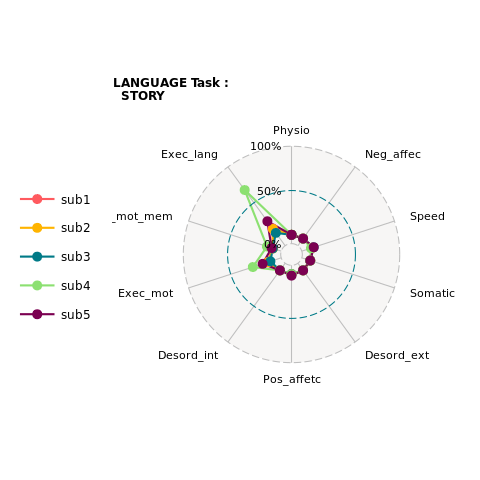

In [34]:
%%R -i path_root,list_subtype_folder,list_trial,task_name

for (tt in list_subtype_folder) {
    path_subtype = paste(path_root,tt,'/',sep = '')
    for (ii in list_trial) {
        MyData <- read.csv(file=paste(path_subtype,ii,"_r2_SVR.csv",sep = ''))
        MyData[MyData < 0] <- 0 # put zero for negative R squared
        # plot R2 radar plot
        image_radar=ggradar(MyData, 
                            grid.min = -0.01,
                            grid.mid = 0.05, 
                            grid.max = 0.1, 
                            axis.label.size = 4, 
                            grid.label.size = 5 ,
                            legend.text.size =5,
                            group.line.width = 1,
                            group.point.size = 4)  +
        theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
        ggtitle(paste(task_name,' Task : \n  ',toupper(ii),sep = ''))
        print(image_radar)
        ggsave(file=paste(path_subtype,ii,"_SVR_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
    }
}

['sub4', 'Cluster_10']


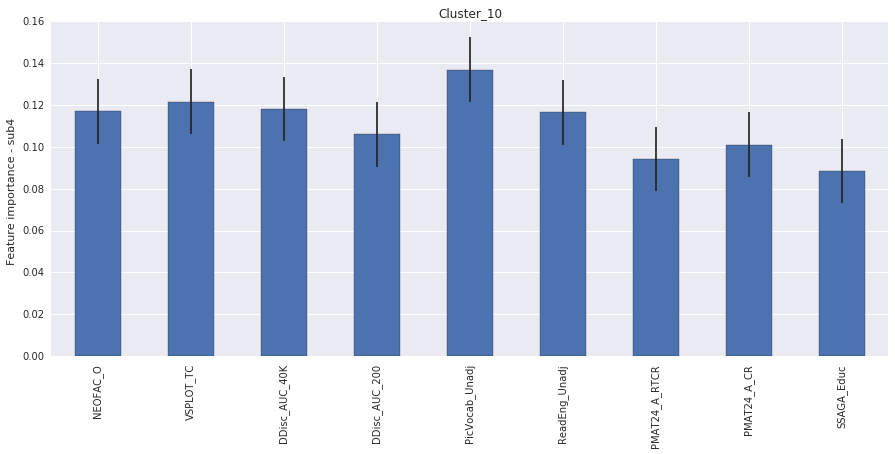

['sub4', 'Cluster_10']


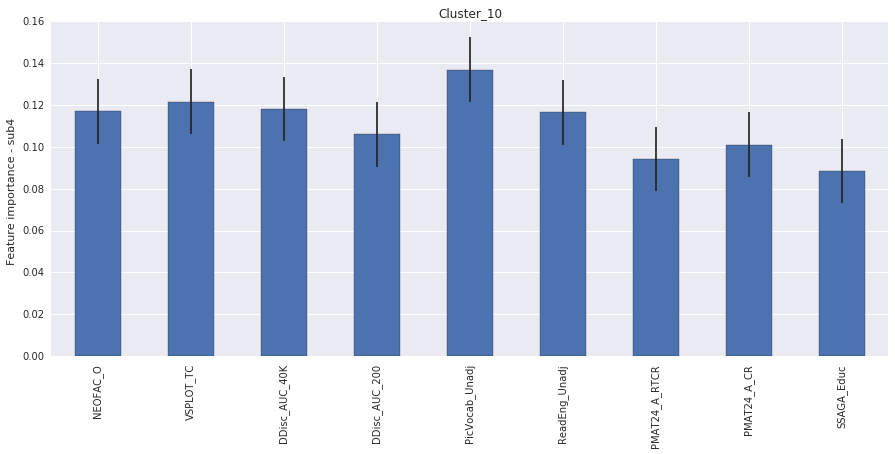

['sub4', 'Cluster_10']


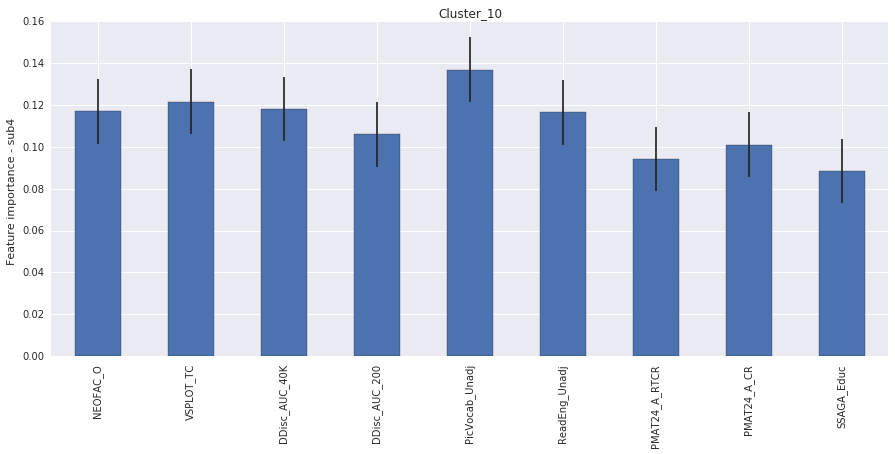

['sub4', 'Cluster_10']


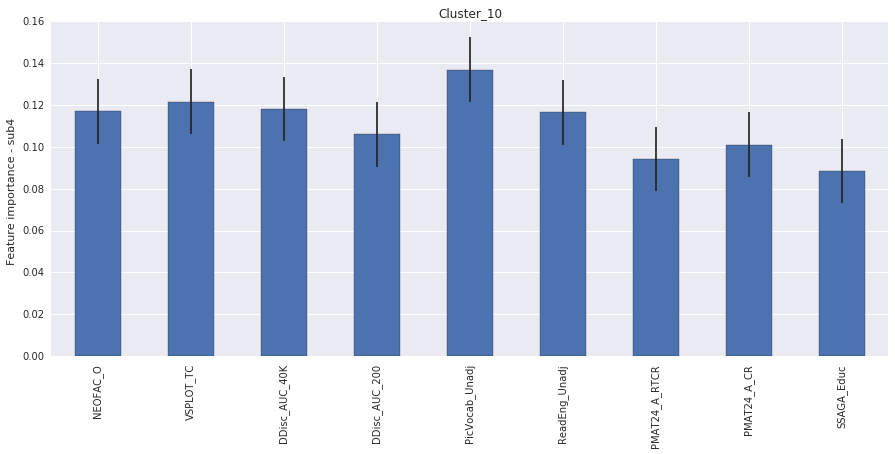

['sub4', 'Cluster_10']


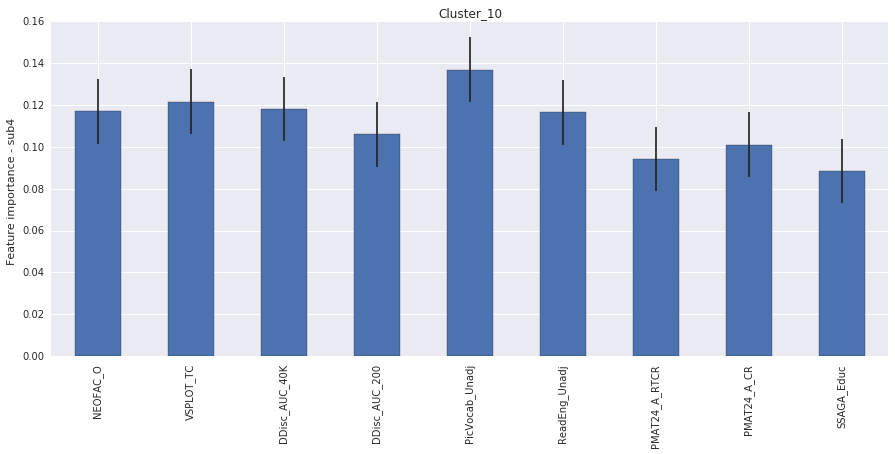

['sub8', 'Cluster_10']


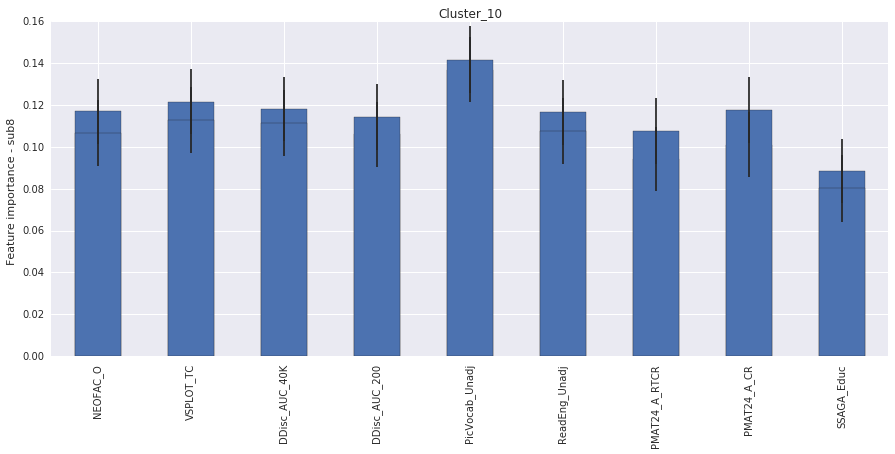

['sub4', 'Cluster_10']


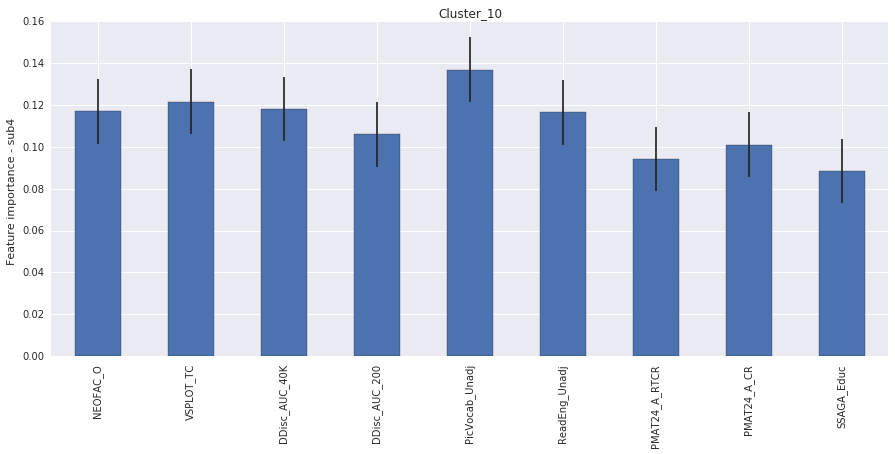

['sub8', 'Cluster_10']


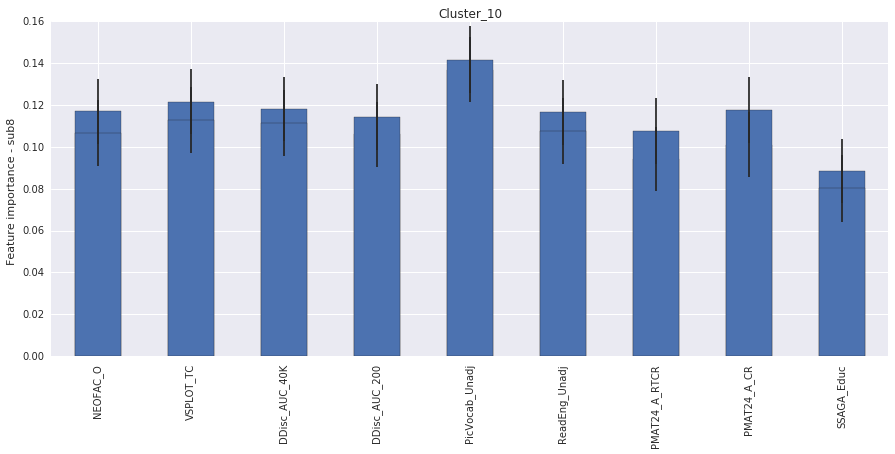

['sub4', 'Cluster_10']


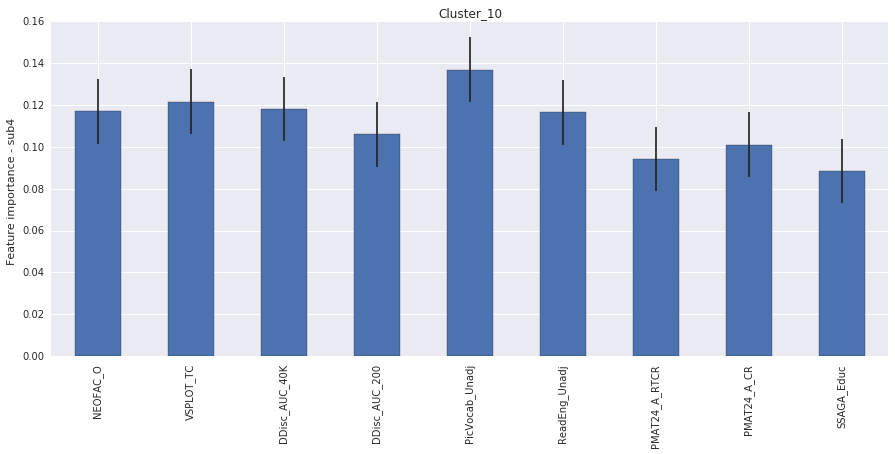

['sub8', 'Cluster_10']


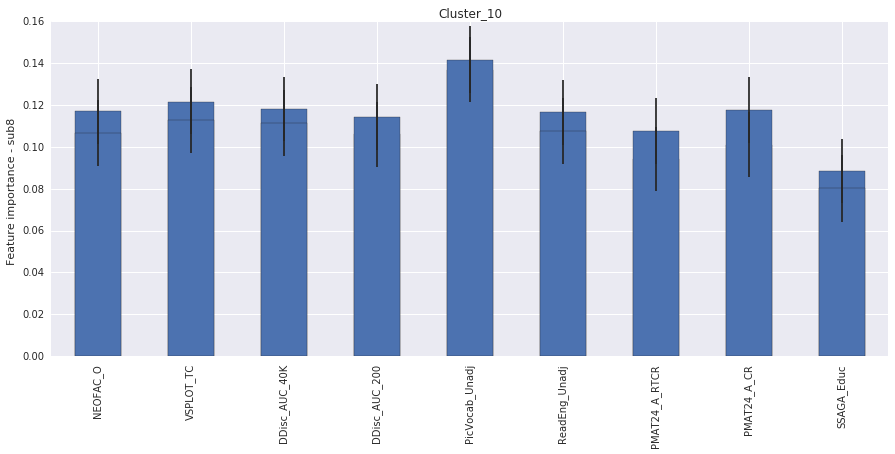

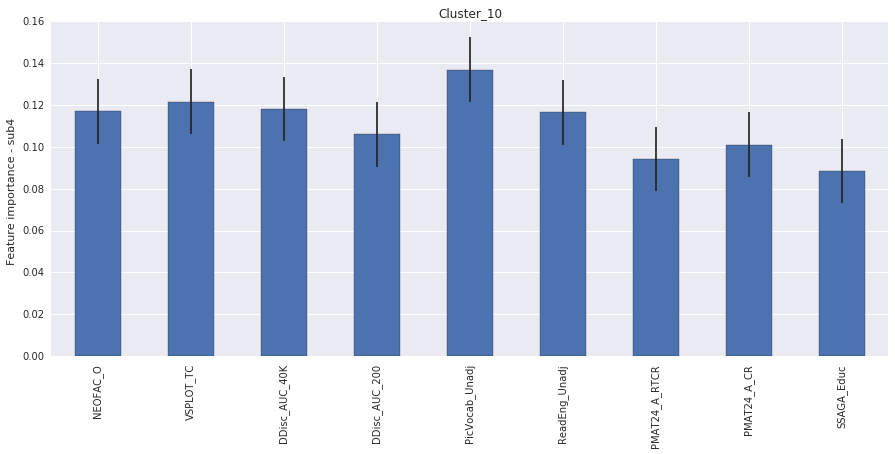

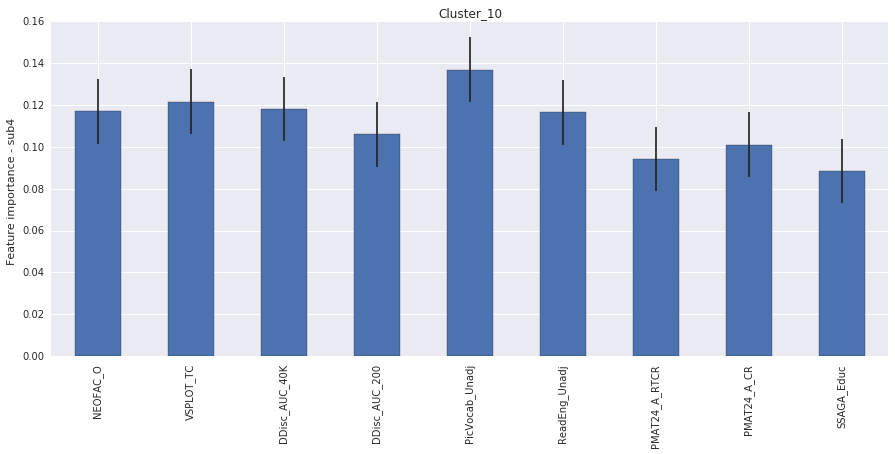

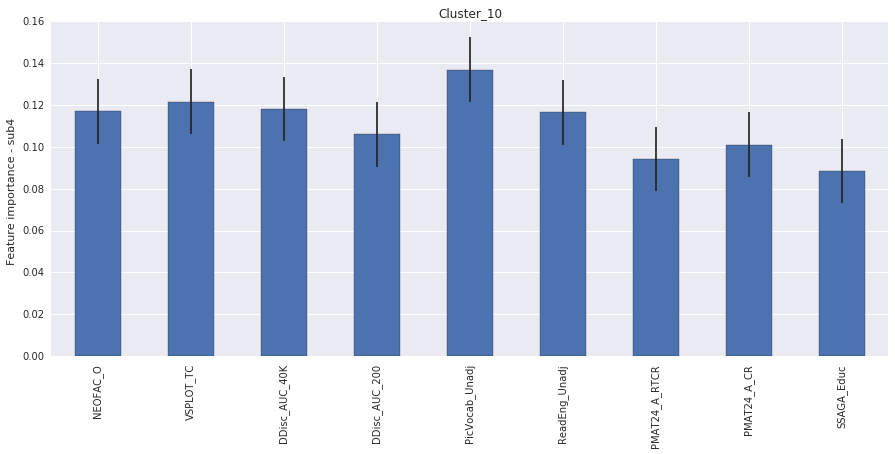

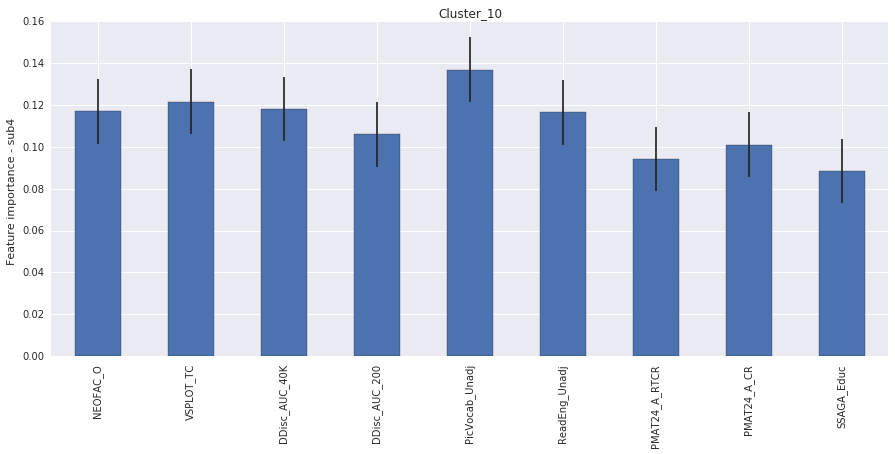

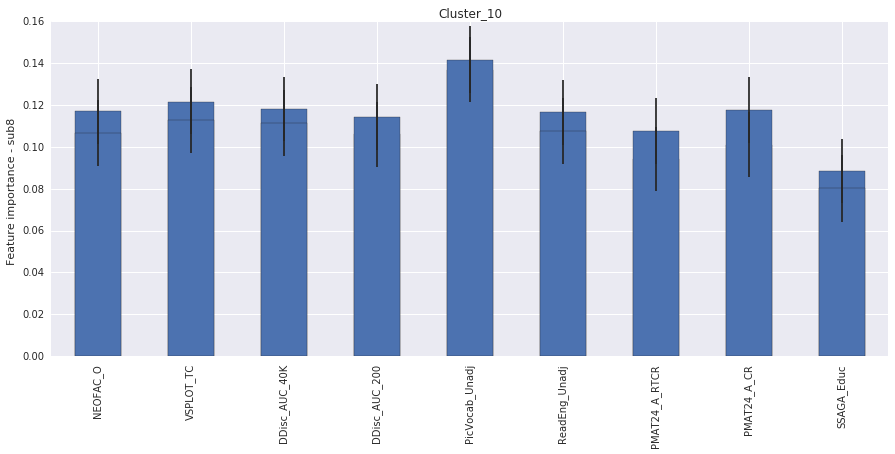

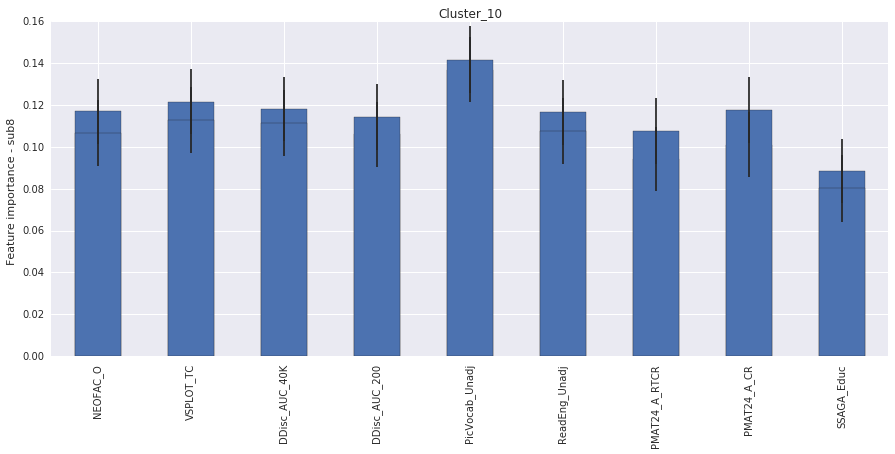

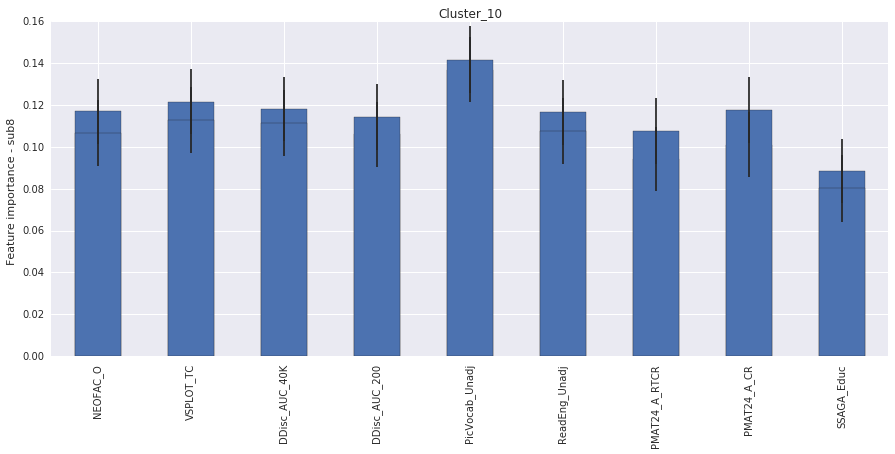

In [103]:
# Plot futures importance
for ind_f , task_folder in enumerate(list_subtype_folder):
    
    # set path and task name
    path_subtype = os.path.join(path_root,task_folder);
    path_association =  os.path.join(path_subtype,'associations/');
    path_networks =  os.path.join(path_subtype,'networks/');
    # number of subtype
    nb_sbt = natural_keys(path_subtype)[9]
    # task name
    task_name = natural_keys(path_subtype)[10][5:-1]
    # List phenotypes
    list_pheno  = [f for f in os.listdir(path_association)]
    list_pheno.sort(key=natural_keys)
    # List trials
    list_trial  = [f for f in os.listdir(path_networks)]
    # List subtype
    list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
    
    for trial_name in list_trial :
        # Retrive stacked data
        all_pheno_pruned_t = dict_all_weight_pheno[task_name + "_" +
                                                   trial_name + "_" +
                                                   str(nb_sbt) + '_subtypes']
        weight_pheno_clust_df_t = dict_all_weight_pheno_clust[task_name + "_" +
                                                              trial_name + "_" +
                                                              str(nb_sbt) + '_subtypes']
        high_r2_t = high_r2_dict[task_name + "_" +
                                 trial_name + "_" +
                                 str(nb_sbt) + '_subtypes']
        # Check if no hight R2 continue
        if not high_r2_t:
            continue

        # Plot and save feature importance
        fig, axs = plt.subplots()
        from IPython.display import display
        for hh in range(np.shape(high_r2_t)[0]):
            X = all_pheno_pruned_t[dict_clusters[high_r2_t[:][hh][1]]]
            x = X.values
            #Rsquared_c = np.zeros((np.shape(list_subtype)))
            y = weight_pheno_clust_df[high_r2_t[:][hh][0]]
            y = y.values
            print(high_r2_t[:][hh])
            Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
            #Rsquared_c[iix] = Rsquared.mean()

            # Threshold future importance
            feimp_thresh =0 # Percentile of future to be removed
            mean_feimp = np.mean(feimp, axis=0)
            mean_std = np.mean(std, axis=0)
            feature_importances = pd.Series(mean_feimp,index= X.columns)
            feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
            std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
            indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]

            # Plot Future importance
            axs.set_ylabel('Feature importance - {} '.format(high_r2_t[:][hh][0]))
            feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],
                                                     figsize=(15,6),
                                                     title='{}'.format(high_r2_t[:][hh][1]),
                                                     ax=axs)
            #fig.subplots_adjust(top=0.88)
            fig.savefig(os.path.join(path_subtype,'fig_FeatImp_{}-{}.svg'.format(high_r2_t[:][hh][1],high_r2_t[:][hh][0])))
            display(fig)

In [126]:
# #### Old version one subtype at time

# #  Set path
# #path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_03-Oct-2017/';
# path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/';
# path_subtype = os.path.join(path_root,'subtype_5_spm_LANGUAGE_18-Oct-2017/');
# path_association =  os.path.join(path_subtype,'associations/');
# path_networks =  os.path.join(path_subtype,'networks/');
# nb_sbt = natural_keys(path_subtype)[9]
# task_name = natural_keys(path_subtype)[10][5:-1]

# # List phenotypes
# list_pheno  = [f for f in os.listdir(path_association)]
# list_pheno.sort(key=natural_keys)
# list_pheno

# # List trials
# list_trial  = [f for f in os.listdir(path_networks)]
# list_trial 

# list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
# list_subtype

# # R_squared radar map NIAK

# # Create R-squared table to be used in R
# for trial_name in list_trial :
#     # build R2 table for radar plot
#     for ix, pheno_name in enumerate(list_pheno):
#         mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
#         %octave_push mat_file
#         %octave mat_load = load(mat_file);
#         %octave_pull mat_load
#         pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
#         if ix == 0:
#             pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
#         else:
#             pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
#     pheno_r2_final.columns = list_pheno
#     pheno_r2_final.index = list_subtype
#     pheno_r2_final = pd.DataFrame(pheno_r2_final)
#     pheno_r2_final.rename(columns=dict_clusters_names).to_csv(os.path.join(path_subtype,'{}_r2.csv'.format(trial_name)))

# pheno_r2_final

### On first run in new machine do
Step 1 — Installing System Dependencies for devtools

`sudo apt-get install build-essential libcurl4-gnutls-dev libxml2-dev libssl-dev libcairo2-dev r-cran-stringr`

Step 2 — Installing the Devtools Package

```sudo -i R
install.packages('devtools')
devtools::install_github("hadley/svglite")
devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)```

In [127]:
# %%R
# library(ggradar)
# library(svglite)
# suppressPackageStartupMessages(library(dplyr))
# library(scales)
# require("ggplot2")

In [128]:
# %%R -i path_subtype,path_association,list_trial,task_name
# for (ii in list_trial) {
#     MyData <- read.csv(file=paste(path_subtype,ii,"_r2.csv",sep = ''))
#     # plot R2 radar plot
#     image_radar=ggradar(MyData, 
#                         grid.min = 0,
#                         grid.mid = 0.05, 
#                         grid.max = 0.1, 
#                         axis.label.size = 4, 
#                         grid.label.size = 5 ,
#                         legend.text.size =5,
#                         group.line.width = 1,
#                         group.point.size = 4)  +
#     theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
#     ggtitle(paste(task_name,' Task : \n  ',toupper(ii),sep = ''))
#     print(image_radar)
#     ggsave(file=paste(path_subtype,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
# }

In [129]:
# # collect weight data
# dict_tmp = {}
# dict_tmp_json = {}
# for ind_t, trial_name in enumerate(list_trial) :
#     # collect all pheno data
#     all_pheno_clust = []
#     names_pheno = []
#     for ix, pheno_name in enumerate(list_pheno):
#         #from IPython.core.debugger import Tracer; Tracer()() 
#         mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
#         %octave_push mat_file
#         %octave mat_load = load(mat_file);
#         %octave_pull mat_load
#         model_x_norm = mat_load['model_norm']['x']
#         model_labels_y_norm = mat_load['model_norm']['labels_y']
#         model_labels_x_norm = mat_load['model_norm']['labels_x']
        
#         my_pheno = np.array(model_x_norm[:,1])
#         my_pheno_name= model_labels_y_norm[1]
#         all_pheno_clust.append(my_pheno)
#         names_pheno.append(my_pheno_name)
        
#     # create pheno dataframe
#     all_pheno_clust = np.concatenate([model_labels_x_norm[...,None],np.transpose(all_pheno_clust)],axis=1)
#     all_pheno_clust_df = pd.DataFrame(all_pheno_clust,columns=np.append('ID',  list_pheno))
#     all_pheno_clust_df['ID'] = all_pheno_clust_df.ID.str.strip()
    
#     #collect weight and create dataframe
#     weight_file = os.path.join(path_networks,'{}/sbt_weights_net_{}.csv'.format(trial_name,trial_name))
#     weight_df = pd.read_csv(weight_file)
#     column_names =np.append('ID',  list_subtype)
#     weight_df.columns= column_names
#     weight_df['ID'] = weight_df.ID.str.strip()
    
#     # merge weight amd pheno dataframe
#     weight_pheno_clust_df=pd.merge(weight_df,all_pheno_clust_df,on='ID',how='left')
#     # save it csv
#     weight_pheno_clust_df.to_csv(os.path.join(path_subtype,'{}_weight_pheno_subtype.csv'.format(trial_name)))
    
#     # stack to dictionary
#     dict_tmp[task_name + "_" + trial_name] = weight_pheno_clust_df
#     # stack to json to be saved later
#     dict_tmp_json[task_name + "_" + trial_name + "_" + str(nb_sbt) + '_subtypes'] = weight_pheno_clust_df.to_json(orient='split')
#     # Merge all pheno with subtype weights
#     all_pheno_pruned = pd.merge(weight_pheno_clust_df[['ID']+list_subtype],all_pheno,on='ID',how='left')
#     # Drop NaN
#     all_pheno_pruned.dropna(inplace=True)

In [130]:
# %%R -i path_subtype,path_association,list_trial,task_name
# for (ii in list_trial) {
#     MyData <- read.csv(file=paste(path_subtype,ii,"_r2_SVR.csv",sep = ''))
#     MyData[MyData < 0] <- 0 # put zero for negative R squared
#     # plot R2 radar plot
#     image_radar=ggradar(MyData, 
#                         grid.min = -0.01,
#                         grid.mid = 0.05, 
#                         grid.max = 0.1, 
#                         axis.label.size = 4, 
#                         grid.label.size = 5 ,
#                         legend.text.size =5,
#                         group.line.width = 1,
#                         group.point.size = 4)  +
#     theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
#     ggtitle(paste(task_name,' Task : \n  ',toupper(ii),sep = ''))
#     print(image_radar)
#     ggsave(file=paste(path_subtype,ii,"_SVR_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
# }

In [131]:
# # Create estimated R-squared table to be used in R
# high_r2_dict= dict()
# for trial_name in list_trial :
#     # build R2 table for radar plot
#     for ix, pheno_name in enumerate(list_pheno):
#         #from IPython.core.debugger import Tracer; Tracer()() 
#         # Set data X Y weight_pheno_clust_df
#         X = weight_pheno_clust_df[[pheno_name]]
#         x = X.values
#         Rsquared_c = np.zeros((np.shape(list_subtype)))
#         for iix, subtype_name in enumerate(list_subtype):
#             y = weight_pheno_clust_df[subtype_name]
#             y = y.values
#             Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
#             Rsquared_c[iix] = Rsquared.mean()
#         if ix == 0:
#             pheno_clust_r2_final = pd.Series(Rsquared_c.tolist())
#         else:
#             pheno_clust_r2_final =pd.concat([pheno_clust_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
    
#     # set R2 table        
#     pheno_clust_r2_final.columns = list_pheno
#     pheno_clust_r2_final.index = list_subtype
#     pheno_clust_r2_final = pd.DataFrame(pheno_clust_r2_final)
#     pheno_clust_r2_final.rename(columns=dict_clusters_names).to_csv(os.path.join(path_subtype,
#                                                                                  '{}_r2_SVR.csv'.format(trial_name)))
    
#     #look for the highest R2 and store feature importance
#     arr = pheno_clust_r2_final.values
#     index_names = pheno_clust_r2_final.index
#     col_names = pheno_clust_r2_final.columns
#     #  Get indices where such threshold is crossed; avoid diagonal elems
#     R,C = np.where(np.triu(arr,1)>0.05)
#     high_r2 = [[index_names[ind_r],col_names[ind_c]] for ind_r,ind_c in zip(R,C)]
#     high_r2_dict[trial_name]= high_r2



# # Plot and save feature importance
# fig, axs = plt.subplots()
# from IPython.display import display
# for hh in range(np.shape(high_r2)[0]):
#     X = all_pheno_pruned[dict_clusters[high_r2[:][hh][1]]]
#     x = X.values
#     Rsquared_c = np.zeros((np.shape(list_subtype)))
#     y = weight_pheno_clust_df[high_r2[:][hh][0]]
#     y = y.values
#     print(high_r2[:][hh])
#     Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
#     Rsquared_c[iix] = Rsquared.mean()
    
    
#     # Threshold future importance
#     feimp_thresh =0 # Percentile of future to be removed
#     mean_feimp = np.mean(feimp, axis=0)
#     mean_std = np.mean(std, axis=0)
#     feature_importances = pd.Series(mean_feimp,index= X.columns)
#     feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
#     std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
#     indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]
    
#     # Plot Future importance
#     axs.set_ylabel('Feature importance - {} '.format(high_r2[:][hh][0]))
#     feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],
#                                              figsize=(15,6),
#                                              title='{}'.format(high_r2[:][hh][1]),
#                                              ax=axs)
#     #fig.subplots_adjust(top=0.88)
#     fig.savefig(os.path.join(path_subtype,'fig_FeatImp_{}-{}.svg'.format(high_r2[:][hh][1],high_r2[:][hh][0])))
#     display(fig)

In [132]:
######junk exp ####

In [133]:
# from sklearn.ensemble import GradientBoostingRegressor
# X_train, X_test, y_train, y_test = train_test_split(X,y)

# clf = GradientBoostingRegressor( max_depth=6, learning_rate=0.04,
#                                 loss='huber', random_state=0)
# clf.fit(X_train, y_train)

# predicted = clf.predict(X_test)
# expected = y_test

# plt.figure(figsize=(10, 4))
# plt.scatter(expected, predicted)
# plt.plot([expected.min(),expected.max()], [expected.min(),expected.max()],'--k')
# plt.axis('tight')
# plt.xlabel('True price ($1000s)')
# plt.ylabel('Predicted price ($1000s)')
# plt.tight_layout()